#IMPORTING LIBRARIES


In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches

# Load data from Excel file

In [138]:
df = pd.read_csv('data.csv')

In [139]:
print(df)

     year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99
1    1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2    1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99
3    1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99
4    1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
787  2023     10     2023.7917   418.82          422.12     27  0.47  0.17
788  2023     11     2023.8750   420.46          422.46     21  0.91  0.38
789  2023     12     2023.9583   421.86          422.58     20  0.68  0.29
790  2024      1     2024.0417   422.80          422.45     27  0.73  0.27
791  2024      2     2024.1250   424.55          423.61     18  1.31  0.59

[792 rows x 8 columns]


# Convert 'month' column to integer

In [140]:
df['month'] = df['month'].astype(int)

# Filter the data for training and testing

In [ ]:
train_data = df[(df['year'] >= 1975)& (df['year'] < 2023)]
test_data = df[(df['year'] == 2023) & (df['month'] == 11)]

In [ ]:
X_train = train_data[['month', 'decimal date', 'deseasonalized','ndays','sdev','unc']].values
y_train = train_data['average'].values

X_test = test_data[['month', 'decimal date', 'deseasonalized','ndays','sdev','unc']].values
y_test = test_data['average'].values

In [ ]:
print(tabulate(train_data[['month', 'decimal date', 'deseasonalized','ndays','sdev','unc']], headers=['month', 'decimal date', 'deseasonalized','ndays','sdev','unc'], tablefmt='psql'))

+-----+---------+----------------+------------------+---------+--------+-------+
|     |   month |   decimal date |   deseasonalized |   ndays |   sdev |   unc |
|-----+---------+----------------+------------------+---------+--------+-------|
| 202 |       1 |        1975.04 |           330.84 |      29 |   0.43 |  0.15 |
| 203 |       2 |        1975.12 |           330.85 |      26 |   0.46 |  0.17 |
| 204 |       3 |        1975.21 |           330.37 |      17 |   0.33 |  0.15 |
| 205 |       4 |        1975.29 |           330.53 |      23 |   0.59 |  0.24 |
| 206 |       5 |        1975.38 |           330.98 |      28 |   0.35 |  0.13 |
| 207 |       6 |        1975.46 |           331.01 |      27 |   0.48 |  0.18 |
| 208 |       7 |        1975.54 |           331.12 |      24 |   0.45 |  0.18 |
| 209 |       8 |        1975.62 |           331.33 |      24 |   0.47 |  0.18 |
| 210 |       9 |        1975.71 |           331.6  |      22 |   0.53 |  0.22 |
| 211 |      10 |        197

In [ ]:
print(f"Training data \n {X_train}")
print(f"Training data \n{y_train}")
print(f"Testing data \n{X_test}")

Training data 
 [[1.0000000e+00 1.9750417e+03 3.3084000e+02 2.9000000e+01 4.3000000e-01
  1.5000000e-01]
 [2.0000000e+00 1.9751250e+03 3.3085000e+02 2.6000000e+01 4.6000000e-01
  1.7000000e-01]
 [3.0000000e+00 1.9752083e+03 3.3037000e+02 1.7000000e+01 3.3000000e-01
  1.5000000e-01]
 ...
 [1.0000000e+01 2.0227917e+03 4.1904000e+02 3.0000000e+01 2.7000000e-01
  1.0000000e-01]
 [1.1000000e+01 2.0228750e+03 4.1947000e+02 2.5000000e+01 5.2000000e-01
  2.0000000e-01]
 [1.2000000e+01 2.0229583e+03 4.1971000e+02 2.4000000e+01 5.7000000e-01
  2.2000000e-01]]
Training data 
[330.73 331.46 331.94 333.11 333.95 333.42 331.97 329.95 328.5  328.36
 329.38 330.77 331.56 332.74 333.36 334.74 334.72 333.98 333.08 330.68
 328.96 328.72 330.16 331.62 332.68 333.17 334.96 336.14 336.93 336.17
 334.89 332.56 331.29 331.28 332.46 333.6  334.94 335.26 336.66 337.69
 338.02 338.01 336.5  334.42 332.36 332.45 333.76 334.91 336.14 336.69
 338.27 338.82 339.24 339.26 337.54 335.72 333.97 334.24 335.32 336.81
 33

In [ ]:
print(y_test)

[420.46]


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3,output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
input_size = X_train.shape[1]
hidden_size1 = 15
hidden_size2 = 12
hidden_size3 = 10
output_size = 1  # Output size (next CO2 reading)
model = MLP(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(3000):
    inputs = torch.tensor(X_train, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    if(epoch%100 ==0):
      print(epoch,loss)
    optimizer.step()

0 tensor(2.7584, grad_fn=<MseLossBackward0>)
100 tensor(2.7279, grad_fn=<MseLossBackward0>)
200 tensor(2.7068, grad_fn=<MseLossBackward0>)
300 tensor(2.6926, grad_fn=<MseLossBackward0>)
400 tensor(2.6833, grad_fn=<MseLossBackward0>)
500 tensor(2.6773, grad_fn=<MseLossBackward0>)
600 tensor(2.6735, grad_fn=<MseLossBackward0>)
700 tensor(2.6712, grad_fn=<MseLossBackward0>)
800 tensor(2.6699, grad_fn=<MseLossBackward0>)
900 tensor(2.6691, grad_fn=<MseLossBackward0>)
1000 tensor(2.6687, grad_fn=<MseLossBackward0>)
1100 tensor(2.6684, grad_fn=<MseLossBackward0>)
1200 tensor(2.6683, grad_fn=<MseLossBackward0>)
1300 tensor(2.6682, grad_fn=<MseLossBackward0>)
1400 tensor(2.6682, grad_fn=<MseLossBackward0>)
1500 tensor(2.6682, grad_fn=<MseLossBackward0>)
1600 tensor(2.6682, grad_fn=<MseLossBackward0>)
1700 tensor(2.6681, grad_fn=<MseLossBackward0>)
1800 tensor(2.6681, grad_fn=<MseLossBackward0>)
1900 tensor(2.6681, grad_fn=<MseLossBackward0>)
2000 tensor(2.6711, grad_fn=<MseLossBackward0>)
2100

In [ ]:
# Print the weights and biases of each layer
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'Weights of {name}: {param.data}')
        print(f'Parameter name: {name}, Shape: {param.shape}')
    elif 'bias' in name:
        print(f'Biases of {name}: {param.data}')
        print(f'Parameter name: {name}, Shape: {param.shape}')


Weights of fc1.weight: tensor([[ 0.0822, -0.3018, -0.0935, -0.0097,  0.2612, -0.1276],
        [ 0.4363,  0.3268, -0.5816,  0.6496,  1.5121, -0.5198],
        [-0.5060,  0.2511,  1.1003,  0.6833,  1.0217,  1.1415],
        [-0.2776,  0.2026, -0.2380,  0.6709,  1.6372,  0.1395],
        [-0.2139, -0.1520, -0.3678, -0.1636, -0.4024, -0.2347],
        [ 0.1992, -0.0413,  0.1724, -0.4210,  0.0706,  0.2743],
        [-0.3804, -0.2175,  0.3411,  0.1884,  0.0876, -0.3960],
        [-0.3755, -0.1073,  0.1749, -0.1610,  0.1741,  0.2599],
        [-0.2781,  0.3777,  0.0484,  0.2136,  0.5091, -0.5812],
        [ 0.0954, -0.2693,  0.0722, -0.3024, -0.1895, -0.3981],
        [-0.2093,  0.2461,  1.1740,  0.9169,  0.7066,  1.0064],
        [-0.5710,  0.1943,  0.9735,  0.1139,  0.9058,  1.2221],
        [-0.1072,  0.0052, -0.1021,  0.0188,  0.2661,  0.0310],
        [ 0.3366, -0.3795,  0.1014,  0.1878,  0.1316, -0.2710],
        [-0.6272,  0.1961,  0.8294,  0.1701,  0.5335,  0.3531]])
Parameter name: 

In [ ]:
with torch.no_grad():
    test_input = torch.tensor(X_test, dtype=torch.float32)
    mlp_prediction = model(test_input).item()

In [ ]:
print("MLP Prediction:", mlp_prediction)

MLP Prediction: 420.5254821777344


# Moving average in built code
## Window size = 5

In [ ]:
# Implement ARMA model
ma_model = ARIMA(y_train, order=(0, 0, 5))
ma_result = ma_model.fit()
ma_prediction = ma_result.forecast()[0]

In [ ]:
print("Moving Average Prediction:", ma_prediction)

Moving Average Prediction: 416.2446659493371


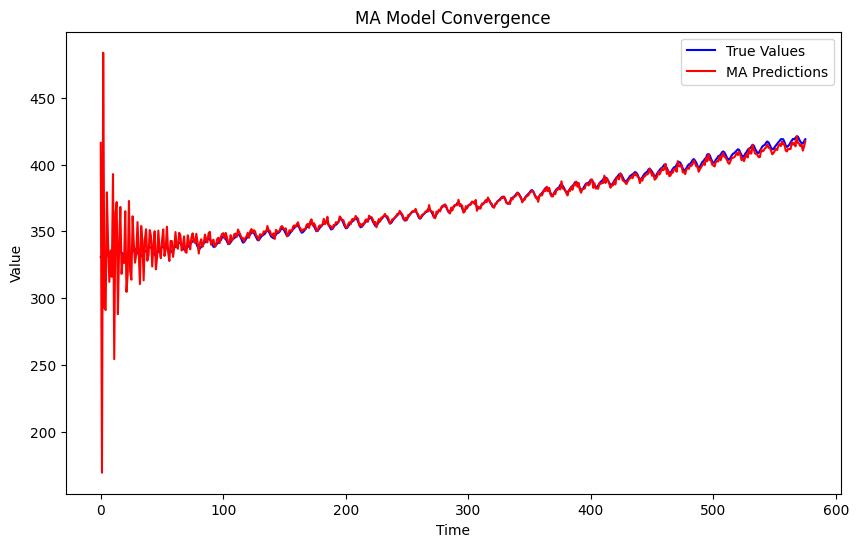

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Generate some example data (true values)
true_values = y_train

# Initialize an MA model
ma_model = ARIMA(true_values, order=(0, 0, 5))

# Initialize an array to store MA predictions
ma_predictions = []
ma_result = ma_model.fit()


# Iterate over time steps and make predictions
for i in range(len(true_values)):
    # Make a one-step ahead forecast
    ma_prediction = ma_result.forecast(steps=1)[0]
    # Append the prediction to the list
    ma_predictions.append(ma_prediction)
    # Add the true value to the model history for the next forecast
    ma_result = ma_result.append([true_values[i]], refit=False)

# Plot true values and MA predictions
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(ma_predictions, label='MA Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MA Model Convergence')
plt.legend()
plt.show()


#Predicting for 1 month using 10 months data

In [152]:
train_data = df[(df['year'] == 2023)& (df['month'] < 11)]
test_data = df[(df['year'] == 2023) & (df['month'] == 11)]

In [153]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3,output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [154]:
input_size = X_train.shape[1]
hidden_size1 = 15
hidden_size2 = 12
hidden_size3 = 10
output_size = 1  # Output size (next CO2 reading)
model = MLP(input_size, hidden_size1, hidden_size2,hidden_size3, output_size)

In [155]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [156]:
for epoch in range(3000):
    inputs = torch.tensor(X_train, dtype=torch.float32)
    labels = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    if(epoch%100 ==0):
      print(epoch,loss)
    optimizer.step()

0 tensor(148533.9688, grad_fn=<MseLossBackward0>)
100 tensor(774.7457, grad_fn=<MseLossBackward0>)
200 tensor(395.8076, grad_fn=<MseLossBackward0>)
300 tensor(393.8789, grad_fn=<MseLossBackward0>)
400 tensor(391.5514, grad_fn=<MseLossBackward0>)
500 tensor(388.8605, grad_fn=<MseLossBackward0>)
600 tensor(385.8275, grad_fn=<MseLossBackward0>)
700 tensor(382.4656, grad_fn=<MseLossBackward0>)
800 tensor(378.7806, grad_fn=<MseLossBackward0>)
900 tensor(374.7752, grad_fn=<MseLossBackward0>)
1000 tensor(370.4460, grad_fn=<MseLossBackward0>)
1100 tensor(365.7863, grad_fn=<MseLossBackward0>)
1200 tensor(360.7851, grad_fn=<MseLossBackward0>)
1300 tensor(355.4267, grad_fn=<MseLossBackward0>)
1400 tensor(349.6902, grad_fn=<MseLossBackward0>)
1500 tensor(343.5486, grad_fn=<MseLossBackward0>)
1600 tensor(336.9677, grad_fn=<MseLossBackward0>)
1700 tensor(329.9048, grad_fn=<MseLossBackward0>)
1800 tensor(322.3044, grad_fn=<MseLossBackward0>)
1900 tensor(314.0938, grad_fn=<MseLossBackward0>)
2000 tens

In [157]:
# Print the weights and biases of each layer
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'Weights of {name}: {param.data}')
        print(f'Parameter name: {name}, Shape: {param.shape}')
    elif 'bias' in name:
        print(f'Biases of {name}: {param.data}')
        print(f'Parameter name: {name}, Shape: {param.shape}')


Weights of fc1.weight: tensor([[-0.3225, -0.2648,  0.3939,  0.3997, -0.2652,  0.0707],
        [-0.1111,  0.1430,  0.6101,  0.2740,  0.6113,  0.4953],
        [-0.0764,  0.3417,  0.2205,  0.1260,  0.3646,  0.2542],
        [-0.1147,  0.1959,  0.3092,  0.3768,  0.7119,  0.6240],
        [-0.4373,  0.3066,  0.4105,  0.1635,  0.3366, -0.0821],
        [-0.4344,  0.2541,  0.4746,  0.4418,  0.7294,  0.2222],
        [ 0.3476, -0.3222, -0.1582,  0.3300, -0.1323,  0.2841],
        [-0.3630, -0.2627,  0.1935,  0.1137, -0.2844,  0.3408],
        [ 0.2000, -0.2012,  0.0794,  0.0868,  0.2499,  0.0023],
        [-0.1496, -0.3529, -0.0709, -0.0596, -0.1933,  0.1616],
        [ 0.2108,  0.3055, -0.0009,  0.1951,  0.8046, -0.1337],
        [ 0.0944, -0.0120,  0.7772,  0.5457,  0.8786,  0.7202],
        [-0.1996,  0.2765,  0.3945,  0.1445,  0.8351,  0.2867],
        [-0.4047, -0.1994, -0.3472, -0.3820,  0.1154, -0.4017],
        [ 0.2075,  0.2261, -0.4827, -0.3358, -0.5398, -0.0684]])
Parameter name: 

In [158]:
with torch.no_grad():
    test_input = torch.tensor(X_test, dtype=torch.float32)
    mlp_prediction = model(test_input).item()

In [159]:
print("MLP Prediction:", mlp_prediction)

MLP Prediction: 416.0380859375


# Moving average in built code
## Window size = 5

In [149]:
# Implement ARMA model
ma_model = ARIMA(y_train, order=(0, 0, 5))
ma_result = ma_model.fit()
ma_prediction = ma_result.forecast()[0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [150]:
print("Moving Average Prediction:", ma_prediction)

Moving Average Prediction: 416.2446659493371


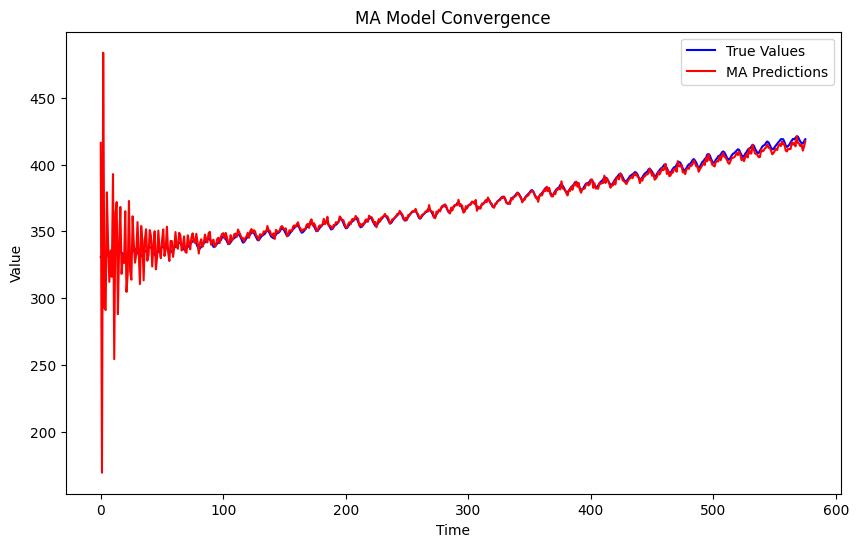

In [151]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Generate some example data (true values)
true_values = y_train

# Initialize an MA model
ma_model = ARIMA(true_values, order=(0, 0, 5))

# Initialize an array to store MA predictions
ma_predictions = []
ma_result = ma_model.fit()


# Iterate over time steps and make predictions
for i in range(len(true_values)):
    # Make a one-step ahead forecast
    ma_prediction = ma_result.forecast(steps=1)[0]
    # Append the prediction to the list
    ma_predictions.append(ma_prediction)
    # Add the true value to the model history for the next forecast
    ma_result = ma_result.append([true_values[i]], refit=False)

# Plot true values and MA predictions
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(ma_predictions, label='MA Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('MA Model Convergence')
plt.legend()
plt.show()


#From Scratch Code

In [ ]:
mu = y_train.mean()
print(mu)

370.26317708333335


In [ ]:
theta1=0.7

#Moving Average 1
$[ X_t = μ  + \theta_1 \varepsilon_{t-1} ]$


(576,)
(576,)


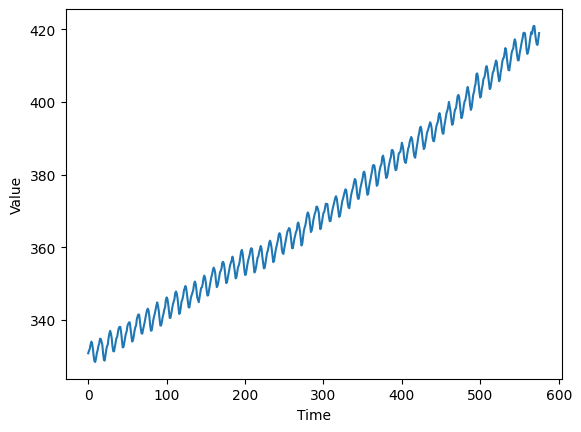

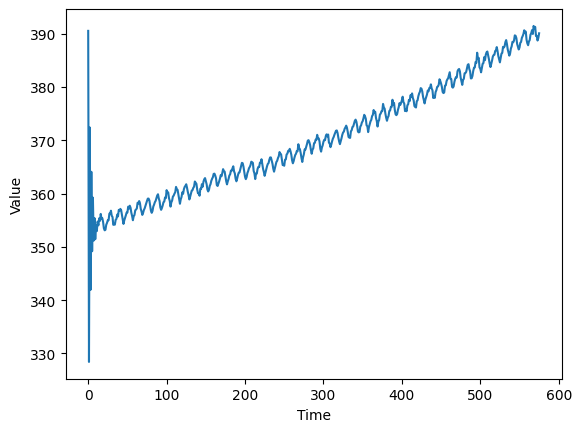

In [ ]:
errorprev = 0
y_pred_array =[]
for i in y_train:
  y_pred = mu+theta1*error
  error = i - y_pred
  y_pred_array.append(y_pred)
y_pred_array = np.array(y_pred_array)
print(y_pred_array.shape)
print(y_train.shape)
plt.plot(y_train, label='Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
plt.plot(y_pred_array, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
y_pred =  mu+theta1*error
y_pred

390.5146733285897

#ARMA Model

In [ ]:
# Implement ARMA model
arma_model = ARIMA(y_train, order=(2, 0, 2))
arma_result = arma_model.fit()
arma_prediction = arma_result.forecast()[0]

In [ ]:
print("ARMA Prediction:", arma_prediction)

ARMA Prediction: 420.073611027035


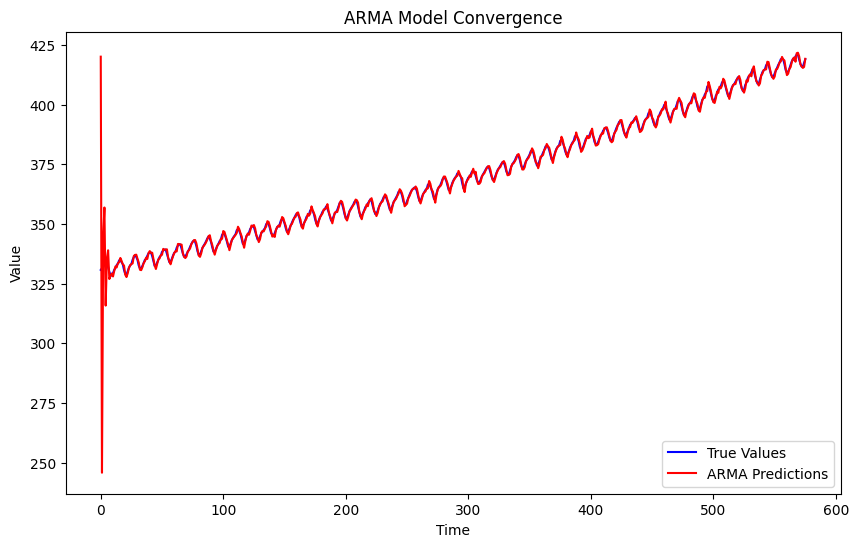

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Generate some example data (true values)
true_values = y_train

# Initialize an ARMA model
arma_model = ARIMA(true_values, order=(2, 0, 2))

# Initialize an array to store ARMA predictions
arma_predictions = []
arma_result = arma_model.fit()


# Iterate over time steps and make predictions
for i in range(len(true_values)):
    # Make a one-step ahead forecast
    arma_prediction = arma_result.forecast(steps=1)[0]
    # Append the prediction to the list
    arma_predictions.append(arma_prediction)
    # Add the true value to the model history for the next forecast
    arma_result = arma_result.append([true_values[i]], refit=False)

# Plot true values and ARMA predictions
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(arma_predictions, label='ARMA Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARMA Model Convergence')
plt.legend()
plt.show()
